# 🧮 Building a mini optimizer library

In the following example an [`optax`](https://optax.readthedocs.io/en/latest/api.html)-like mini-library is built using `PyTreeClass`

The main difference is that the optimizer state is a pytree instance of `TreeClass` and inherits all its pros.

In [1]:
import jax
import jax.numpy as jnp
import pytreeclass as pytc
from typing import Any, TypeVar, Generic, Callable
import abc
import matplotlib.pyplot as plt

PyTree = Any
T = TypeVar("T")


class GradientTransformation(pytc.TreeClass, Generic[T]):
    # TreeClass inherits from `abc.ABC`
    # following the same pattern as `optax` optimizers
    # https://github.com/deepmind/optax/blob/fc5de3d3951c4dfd87513c6426e30baf505d89ae/optax/_src/base.py#L85
    @abc.abstractclassmethod
    def update(self, _: T) -> tuple[T, "GradientTransformation"]:
        pass


def moment_update(grads, moments, *, beta: float, order: int):
    def moment_step(grad, moment):
        return beta * moment + (1 - beta) * (grad**order)

    return jax.tree_map(moment_step, grads, moments)


def debias_update(moments, *, beta: float, count: int):
    def debias_step(moment):
        return moment / (1 - beta**count)

    return jax.tree_map(debias_step, moments)


def ema(decay_rate: float, debias: float = True) -> GradientTransformation:
    """Exponential moving average

    Args:
        decay_rate: The decay rate of the moving average.
        debias: Whether to debias the moving average.
    """

    class EMA(GradientTransformation):
        def __init__(self, tree):
            self.state = jax.tree_map(jnp.zeros_like, tree)
            self.count = 0

        def _update(self, grads: T) -> T:
            self.count += 1
            self.state = moment_update(grads, self.state, beta=decay_rate, order=1)
            if debias:
                return debias_update(self.state, beta=decay_rate, count=self.count)
            return self.state

        def update(self, grads: T) -> tuple[T, "EMA"]:
            return self.at["_update"](grads)

    return EMA


def adam(
    *,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
) -> GradientTransformation:
    """Adam optimizer

    Args:
        beta1: The decay rate of the first moment.
        beta2: The decay rate of the second moment.
        eps: A small value to prevent division by zero.

    Note:
        Kingma et al, 2014: https://arxiv.org/abs/1412.6980
    """

    class Adam(GradientTransformation):
        def __init__(self, tree):
            self.mu = jax.tree_map(jnp.zeros_like, tree)
            self.nu = jax.tree_map(jnp.zeros_like, tree)
            self.count = 0

        def _update(self, grads: T) -> T:
            self.count += 1
            self.mu = moment_update(grads, self.mu, beta=beta1, order=1)
            self.nu = moment_update(grads, self.nu, beta=beta2, order=2)
            mu_hat = debias_update(self.mu, beta=beta1, count=self.count)
            nu_hat = debias_update(self.nu, beta=beta2, count=self.count)
            return jax.tree_map(
                lambda mu, nu: mu / (jnp.sqrt(nu) + eps), mu_hat, nu_hat
            )

        def update(self, grads: T) -> tuple[T, "Adam"]:
            # since self._update mutates the state, we need to use self.at
            # to return the method value and the mutated state
            return self.at["_update"](grads)

    return Adam


def scale(rate: float) -> GradientTransformation:
    """Scale the gradients by a constant factor"""

    class Scale(GradientTransformation):
        def __init__(self, _=None):
            self.rate = rate

        def _update(self, grads: T) -> T:
            return jax.tree_map(lambda x: x * self.rate, grads)

        def update(self, grads: T) -> tuple[T, "Scale"]:
            return self.at["_update"](grads)

    return Scale


def chain(
    *transformations: tuple[GradientTransformation, ...]
) -> GradientTransformation:
    """Chain multiple transformations together similar to `optax.chain`"""

    class Chain(GradientTransformation):
        def __init__(self, tree):
            self.transformations = tuple(T(tree) for T in transformations)

        def _update(self, grads: T) -> T:
            state = []
            for transformation in self.transformations:
                grads, optim_state = transformation.update(grads)
                state += [optim_state]
            self.transformations = tuple(state)
            return grads

        def update(self, grads: T) -> tuple[T, "Chain"]:
            return self.at["_update"](grads)

    return Chain

Epoch=1000	Loss: 3.562e-03
Epoch=2000	Loss: 8.820e-04
Epoch=3000	Loss: 3.672e-04
Epoch=4000	Loss: 2.218e-04
Epoch=5000	Loss: 1.894e-04
Epoch=6000	Loss: 1.693e-04
Epoch=7000	Loss: 1.427e-04
Epoch=8000	Loss: 1.133e-04
Epoch=9000	Loss: 7.974e-05
Epoch=10000	Loss: 7.325e-05


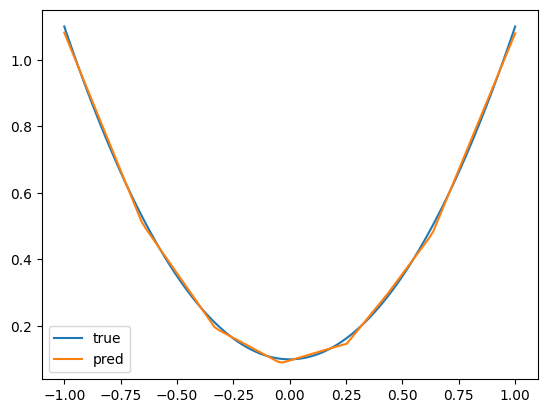

In [2]:
# Test it with a simple neural network

params = {
    "w1": jax.random.normal(jax.random.PRNGKey(0), [1, 10]),
    "b1": jnp.zeros([10], dtype=jnp.float32),
    "w2": jax.random.normal(jax.random.PRNGKey(1), [10, 1]),
    "b2": jnp.zeros([1], dtype=jnp.float32),
}

optim = chain(adam(), scale(-1e-3))
optim_state = optim(params)


def forward(params: dict[str, jax.Array], x: jax.Array):
    x = x @ params["w1"] + params["b1"]
    x = jax.nn.relu(x)
    x = x @ params["w2"] + params["b2"]
    return x


def loss_func(params: dict[str, jax.Array], x: jax.Array, y: jax.Array) -> jax.Array:
    return jnp.mean((forward(params, x) - y) ** 2)


@jax.jit
def train_step(params, optim_state, x, y):
    grads = jax.grad(loss_func)(params, x, y)
    grads, optim_state = optim_state.update(grads)
    params = jax.tree_map(lambda p, g: p + g, params, grads)
    return params, optim_state


x = jnp.linspace(-1, 1, 100).reshape(-1, 1)
y = x**2 + 0.1

for i in range(1, 10_000 + 1):
    params, optim_state = train_step(params, optim_state, x, y)
    if i % 1_000 == 0:
        print(f"Epoch={i:003d}\tLoss: {loss_func(params, x, y):.3e}")

plt.plot(x, y, label="true")
plt.plot(x, forward(params, x), label="pred")
plt.legend()